<a href="https://colab.research.google.com/github/alex-mat-s/Sunspots-Forecasting-ARIMA-LSTM/blob/main/Task_1_LSTM_ARIMA_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00


In [283]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings
import itertools
import math
from pmdarima import arima
from tqdm import tqdm
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

In [4]:
%matplotlib inline
sns.set_style("whitegrid")

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


##Functions declarations

In [6]:
def plot_seasons(data, period):
    """The function plot the data with seasonality.
    """
    data_len = len(data)
    line_id = 0
    ax = data.plot(figsize=(15,5),  ylabel='Total Sunspot Number')
    while data_len > 0:
        ax.axvline(data.index[line_id], color="red", linestyle="--")
        line_id += period
        data_len -= period

In [7]:
def plot_decomposition(x_data, years, period):
    ts_dicomposition = sm.tsa.seasonal_decompose(x_data, model='additive', period=period)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid

    fig, axes = plt.subplots(4, 1)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    # First plot is the Original time series
    axes[0].plot(x_data, label='Original')
    axes[0].legend(loc='upper left')
    # Second plot is the trend
    axes[1].plot(trend_estimate, label='Trend')
    axes[1].legend(loc='upper left')
    # Third plot is the Seasonality component
    axes[2].plot(seasonal_estimate, label='Seasonality')
    axes[2].legend(loc='upper left')
    # The last plot is the Residual component
    axes[3].scatter(years, residual_estimate, label='Residuals', s=2)
    axes[3].legend(loc='upper left')

In [8]:
def plot_acf_pacf(x_data, acf_lags, pacf_lags):
    fig, ax = plt.subplots(2, 1, figsize=(20,8))
    # autocorrelation
    sm.graphics.tsa.plot_acf(x_data, lags=acf_lags, ax=ax[0])
    # partial autocorrelation
    sm.graphics.tsa.plot_pacf(x_data, lags=pacf_lags, ax=ax[1])

    plt.show()

In [9]:
def calculate_period(data, resample=False):
    acf_val = sm.tsa.stattools.acf(data, nlags=len(data))
    period_lst = []
    for i in range(len(acf_val) - 1):
        if acf_val[i] * acf_val[i+1] < 0:
            period_lst.append(i)

    if len(period_lst) % 2 != 0:
        period_lst = period_lst[:-1]

    curr_id = 0
    period_diff = []
    while curr_id + 2 < len(period_lst):
        period_diff.append(period_lst[curr_id+2] - period_lst[curr_id])
        curr_id += 2

    period = sum(period_diff) / len(period_diff)
    if resample:
        print(f"The duration of the season is equal to: {period * 3} months ({period / 4} years)" )
    else:
        print(f"The duration of the season is equal to: {period} months ({period / 12} years)" )
    plot_seasons(data, round(period))

    return period

In [10]:
def adfuller_test(x_data):
    #print("Dickey-Fuller test:", sm.tsa.stattools.adfuller(data["Monthly Mean Total Sunspot Number"])[1])
    p_value = sm.tsa.stattools.adfuller(x_data)[1]
    print("Dickey-Fuller test:", p_value)
    if p_value < 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [11]:
def train_test_split(data):
    n = len(data) - math.floor(len(data) / 5)
    return data[:n], data[n:]

In [12]:
def resample_quarter(data):
    return data.resample('Q').mean()

In [13]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

In [14]:
def calculate_r2_score(y, y_pred):
    return round(r2_score(y, y_pred), 4)

In [289]:
def calculate_mape(y, y_pred):
    return round(mean_absolute_percentage_error(y, y_pred), 3) * 100

In [251]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


def prepare_data(data, n_lag):
    scaler = MinMaxScaler()
    data_scale = scaler.fit_transform(data)

    data_train, data_test = train_test_split(data_scale)

    time_steps = round(n_lag)
    X_train, y_train = create_dataset(data_train, data_train, time_steps)
    X_test, y_test = create_dataset(data_test, data_test, time_steps)

    print(len(X_train), len(X_test))

    return X_train, y_train, X_test, y_test, scaler


def fit_lstm(X_train, y_train, n_neurons, n_lag, nb_epoch, batch_size):
    # Instantiate a Sequential model
    model = Sequential()

    # Add the first LSTM layer with 64 units, making sure it returns sequences to allow for stacking LSTM layers
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(n_lag, 1)))
    # Add the second LSTM layer with 64 units
    model.add(LSTM(n_neurons, return_sequences=True))
    # Add the third LSTM layer with 32 units
    model.add(LSTM(n_neurons//2))
    # Add a Dense layer with 32 units and ReLU activation function
    model.add(Dense(n_neurons//2, activation="relu"))
    # Add the output Dense layer with a single unit (for regression)
    model.add(Dense(1))

    # Compile the model using Nadam optimizer and mean squared error as the loss function
    model.compile(optimizer='adam', loss='mse', metrics="mae")

    # Define a callback to reduce the learning rate when the validation loss plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=25, min_lr=1e-5)
    # Define a callback for early stopping to prevent overfitting and restore the best model weights
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # reshape training into [samples, timesteps, features]
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        if i % 2 == 0:
            print(i)
        hist = model.fit(X_train, y_train, validation_split=0.1,epochs=1,
                         batch_size=batch_size, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())

    return model, history_loss, history_val_loss

##Data

<ipython-input-17-5771e02c4261>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  dataset = pd.read_csv("/content/drive/My Drive/ITMO/AMLT'23/Task1/Data/Sunspots.csv",


<Axes: xlabel='Months since January 1749', ylabel='Monthly Mean Total Sunspot Number'>

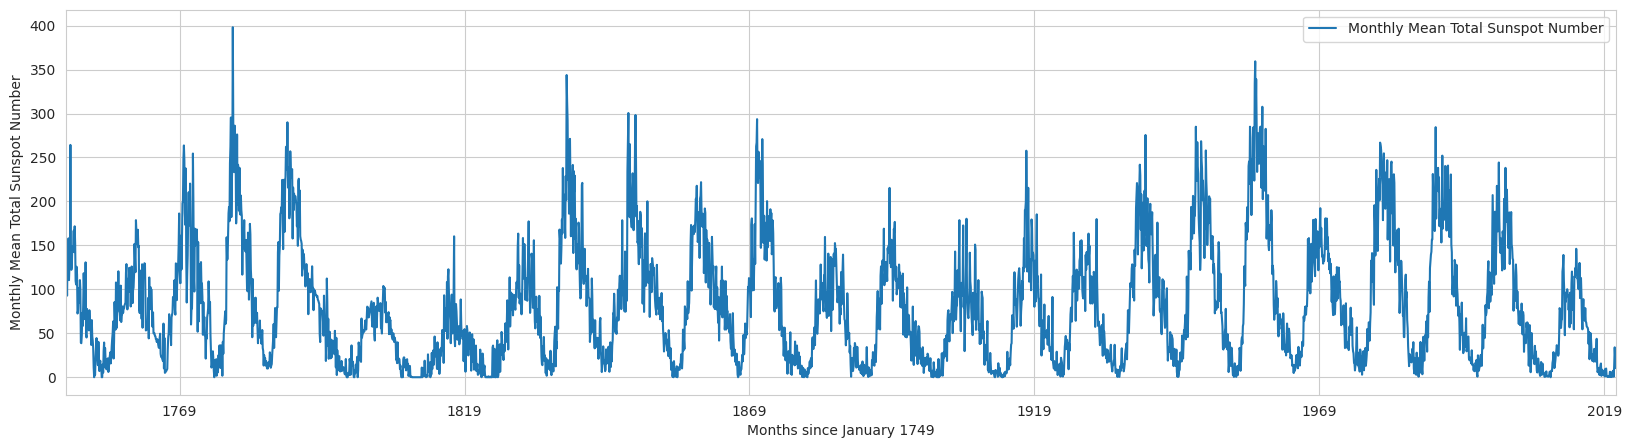

In [17]:
dataset = pd.read_csv("/content/drive/My Drive/ITMO/AMLT'23/Task1/Data/Sunspots.csv",
                   ',', index_col=['Date'], header=0, parse_dates=['Date'],
                   dayfirst=True,encoding='cp1251')
dataset.plot(xlabel='Months since January 1749', ylabel='Monthly Mean Total Sunspot Number', figsize=(20, 5))

**Information about the dataset**

Sunspots are phenomena on the Sun's photosphere that appear as temporary spots that are darker than the surrounding areas. Their number varies according to the approximately *11-year solar cycle*. (https://en.wikipedia.org/wiki/Sunspot)

**Data:** Monthly Mean Total Sunspot Number, from 1749/01/01 to 2017/08/31

Database from SIDC - Solar Influences Data Analysis Center - the solar physics research department of the Royal Observatory of Belgium. SIDC website





In [18]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


For work, let's take the time period from 1921-01-31 to 2021-01-31

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1089 entries, 1930-05-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Monthly Mean Total Sunspot Number  1089 non-null   float64
dtypes: float64(1)
memory usage: 17.0 KB
None


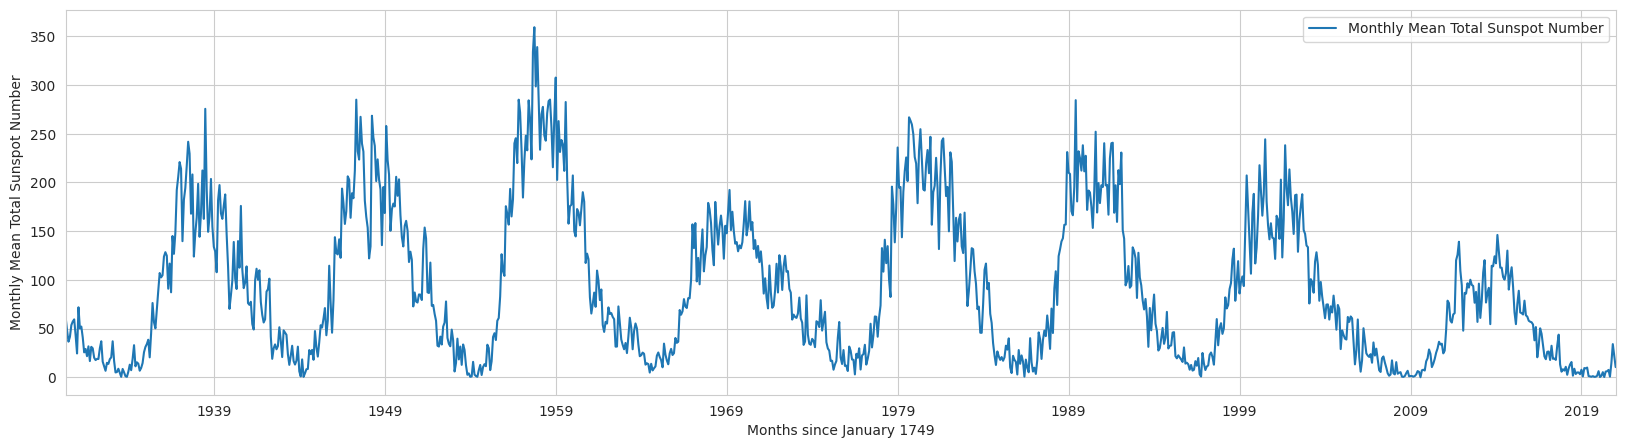

In [19]:
data = dataset[-len(dataset)//3:]
data.plot(xlabel='Months since January 1749', ylabel='Monthly Mean Total Sunspot Number', figsize=(20, 5))
print(data.info(verbose=True))

###EDA for Time-Series

Properties:
1. There is no trend in the data
2. According to the information reference, this data set has the property of seasonality, it will be proved futher
3. There are no errors
4. The time-series is non-stationary (since seasonality is observed)
5. Heteroscedasticity

**Seasonality**

As you can see from the figure below the dataset the data for each eleven-year period have similar behavior, which proves the presence of the seasonality property

As we can see from the general picture, the data have seasonality. Let's define this period.

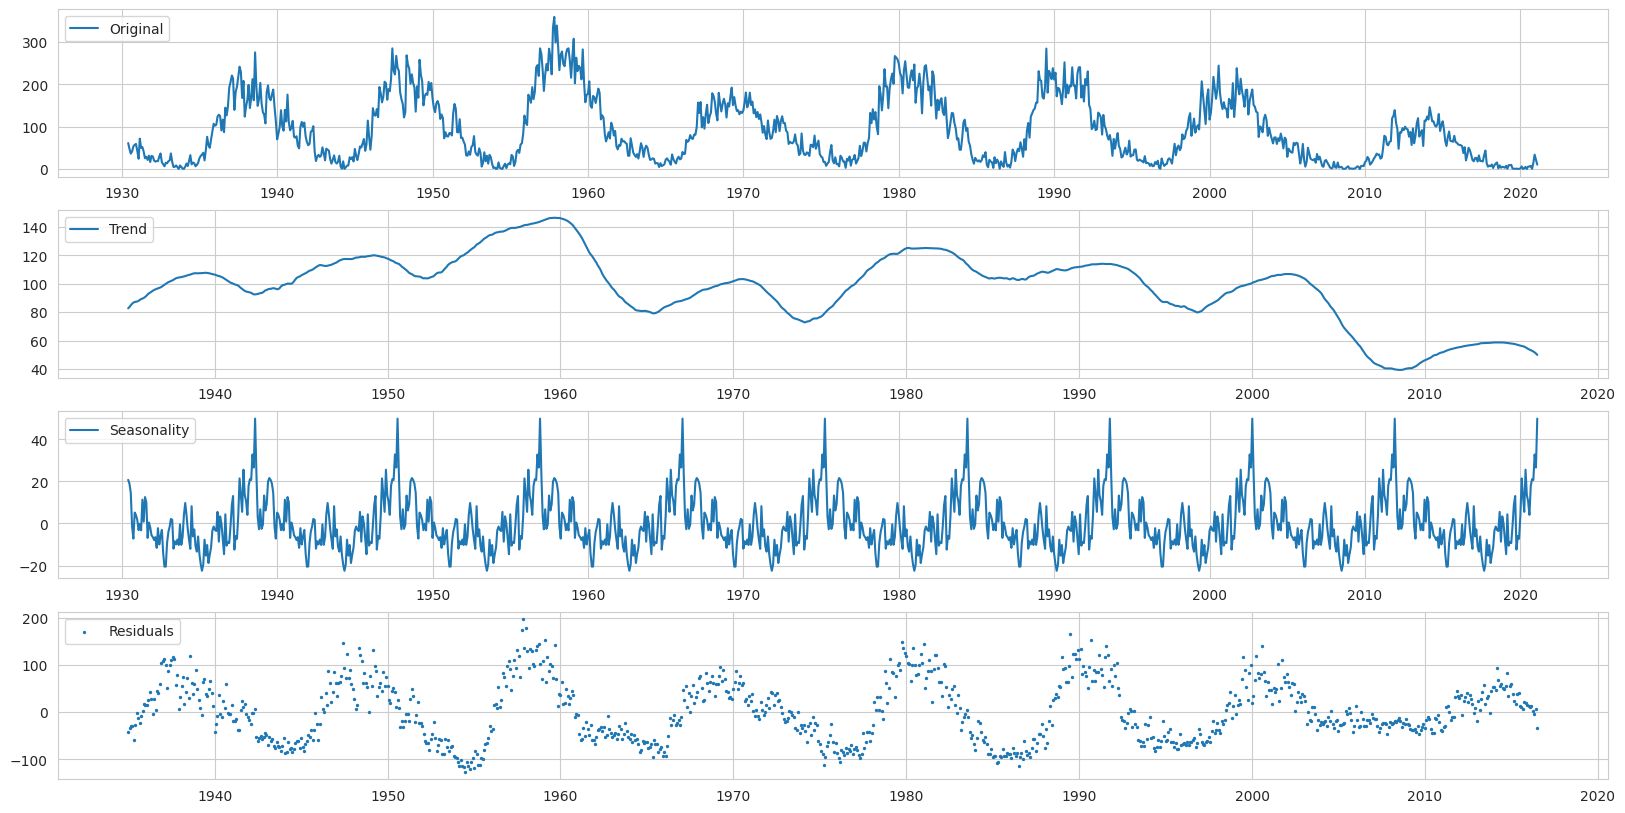

In [20]:
plot_decomposition(data["Monthly Mean Total Sunspot Number"], data.index, period=110)

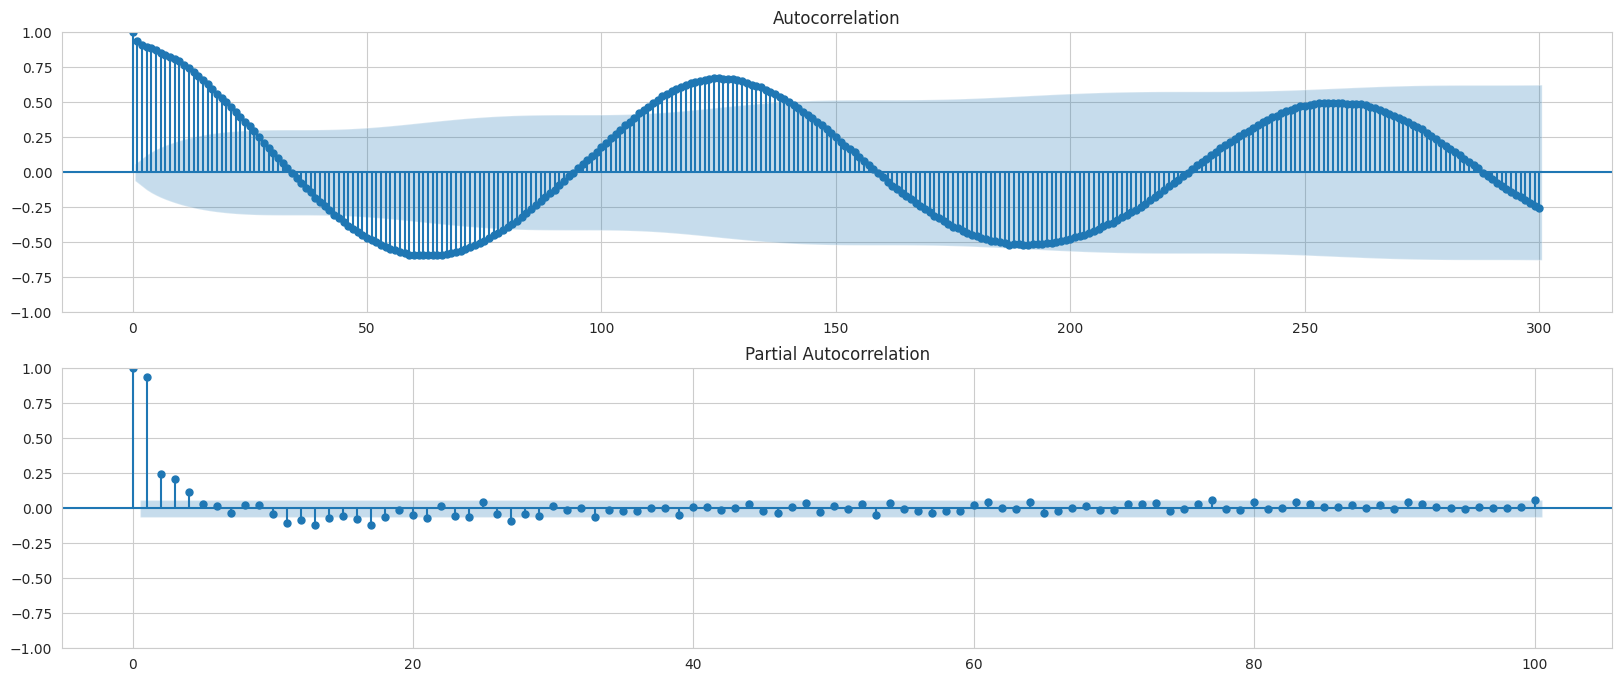

In [21]:
plot_acf_pacf(data, acf_lags=300, pacf_lags=100)

The duration of the season is equal to: 129.57142857142858 months (10.79761904761905 years)


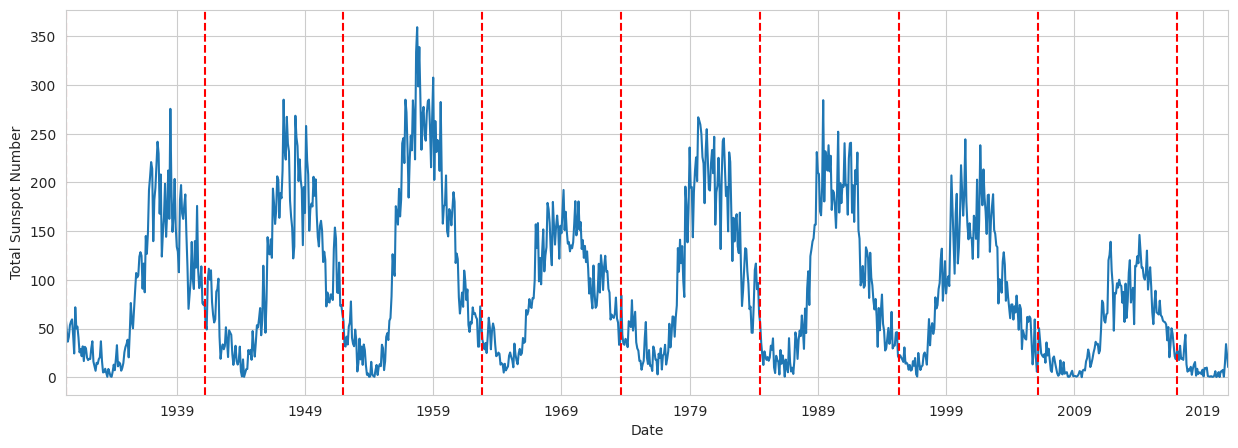

In [22]:
period = calculate_period(data["Monthly Mean Total Sunspot Number"])

**Lag Plot**

As we can see from the plot below the data is not random.

Text(0.5, 1.0, 'Lag plot of sunspot numbers')

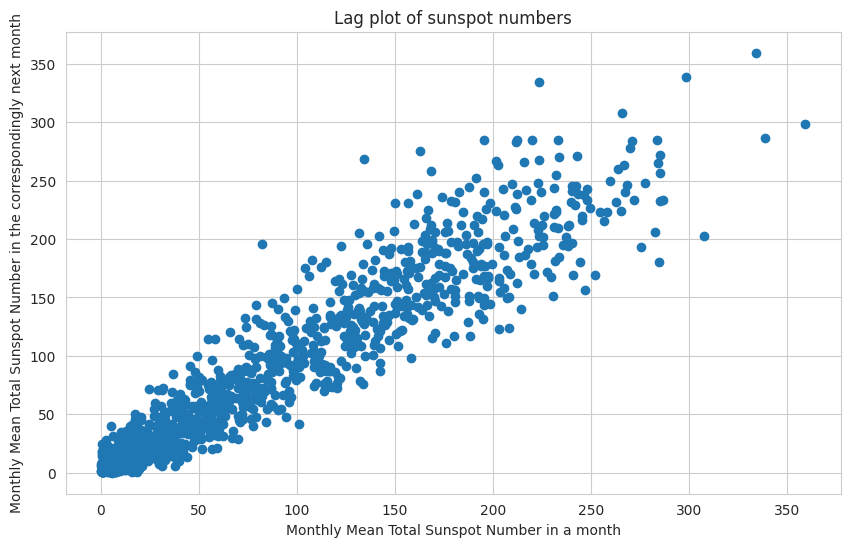

In [23]:
plt.figure(figsize=(10,6))
ax = pd.plotting.lag_plot(data)
ax.set_xlabel('Monthly Mean Total Sunspot Number in a month')
ax.set_ylabel('Monthly Mean Total Sunspot Number in the correspondingly next month')
ax.set_title('Lag plot of sunspot numbers')

##Re-sampling

Let's re-sample the data by quarter (since for the SARIMA model, calculations for such a long period will be too expensive in memory and time)

In [24]:
data_resample = pd.DataFrame({'Mean Total Sunspot Number': []})
data_resample['Mean Total Sunspot Number'] = resample_quarter(data["Monthly Mean Total Sunspot Number"])
data_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 1930-06-30 to 2021-03-31
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mean Total Sunspot Number  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [25]:
data_resample[:10]

,Mean Total Sunspot Number
Date,
1930-06-30,54.700000
1930-09-30,43.833333
1930-12-31,53.200000
1931-03-31,48.766667
1931-06-30,39.433333
1931-09-30,27.433333
1931-12-31,25.833333
1932-03-31,18.833333
1932-06-30,28.433333


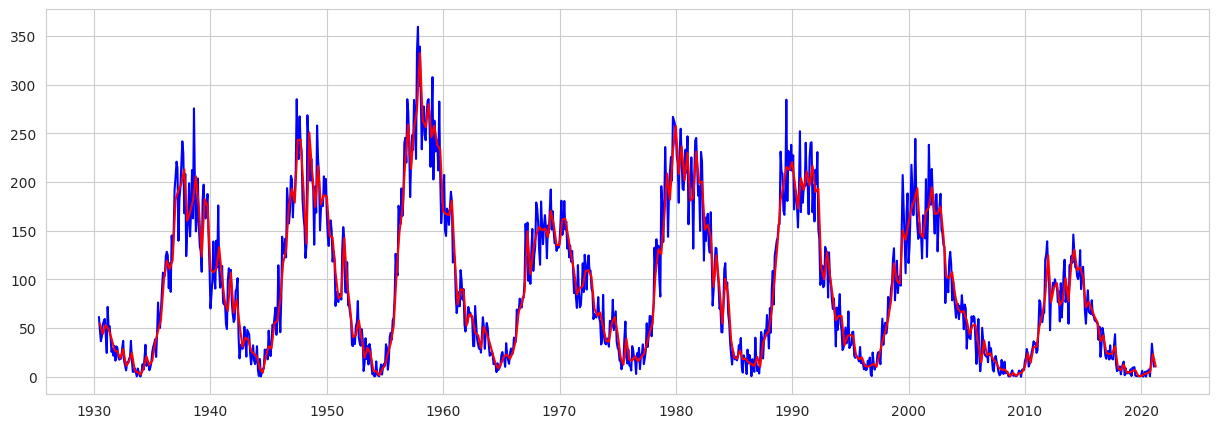

In [26]:
plt.figure(figsize=(15,5))
plt.plot(data["Monthly Mean Total Sunspot Number"], color="blue")
plt.plot(data_resample['Mean Total Sunspot Number'], color="red")

The duration of the season is equal to: 129.42857142857144 months (10.785714285714286 years)


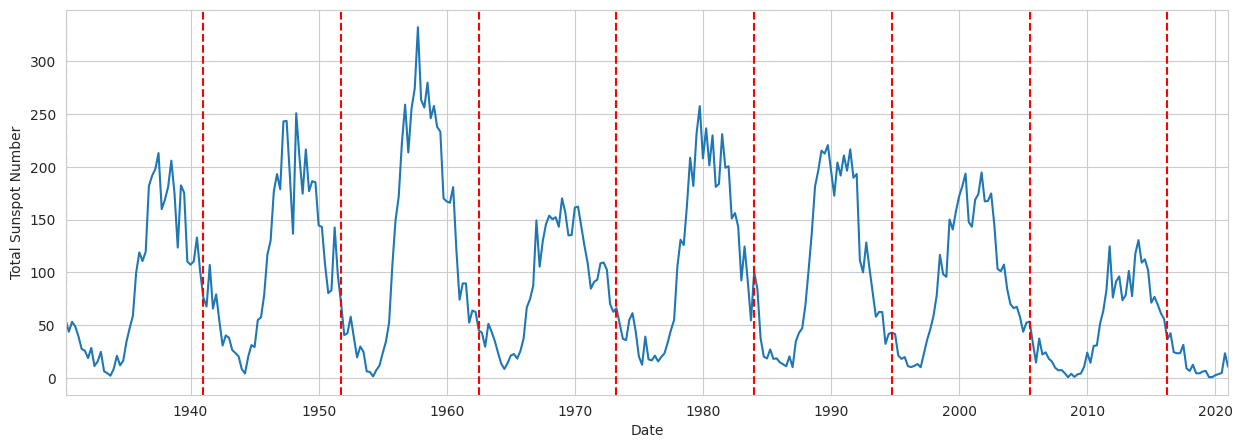

In [27]:
period_resample = calculate_period(data_resample['Mean Total Sunspot Number'], resample=True)

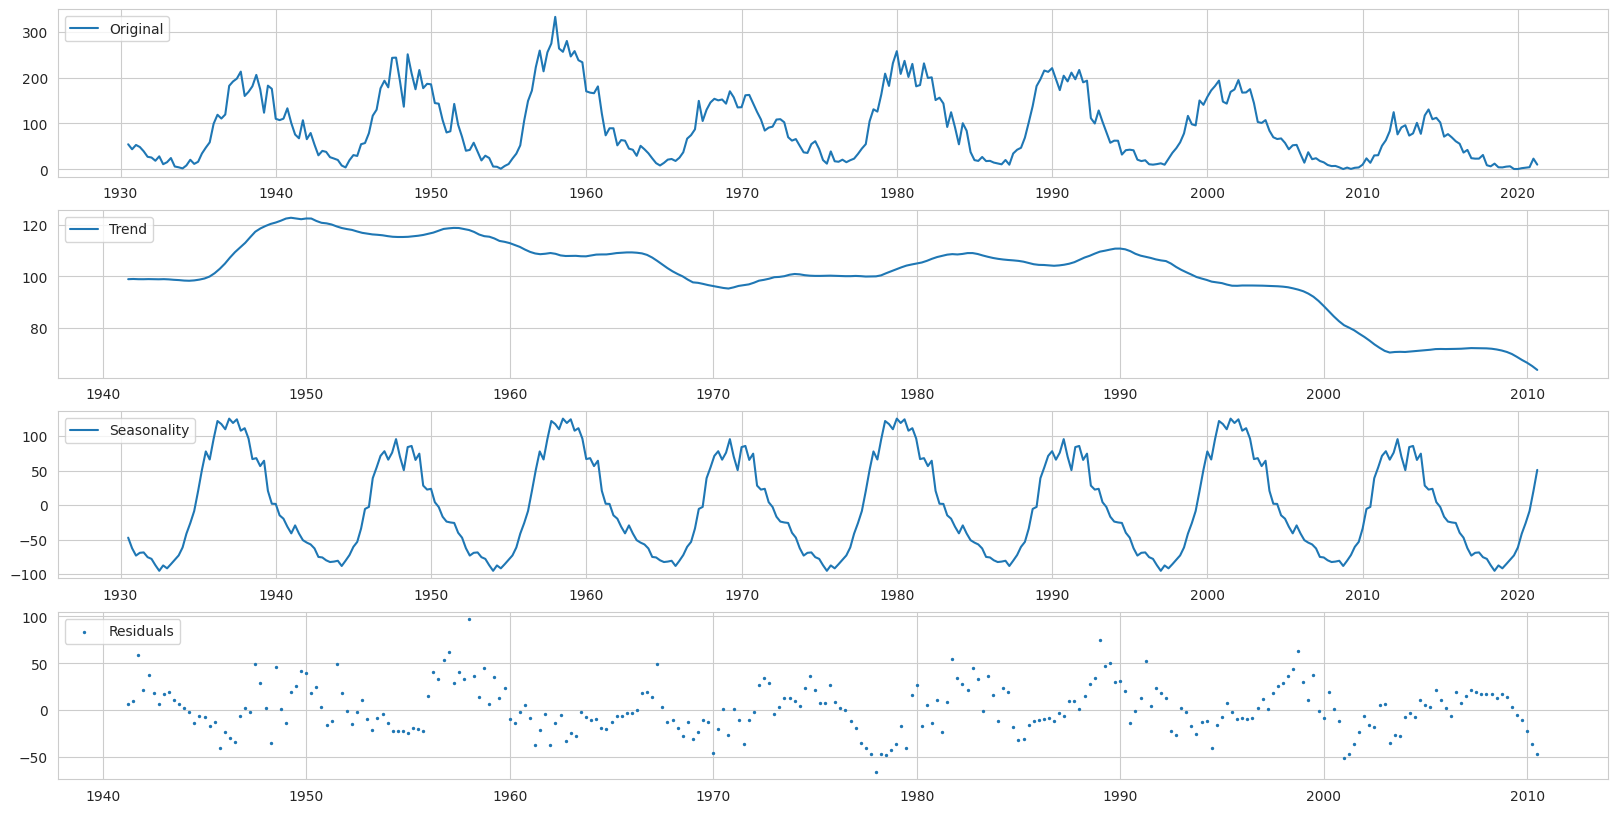

In [28]:
plot_decomposition(data_resample['Mean Total Sunspot Number'], data_resample.index, period=86)

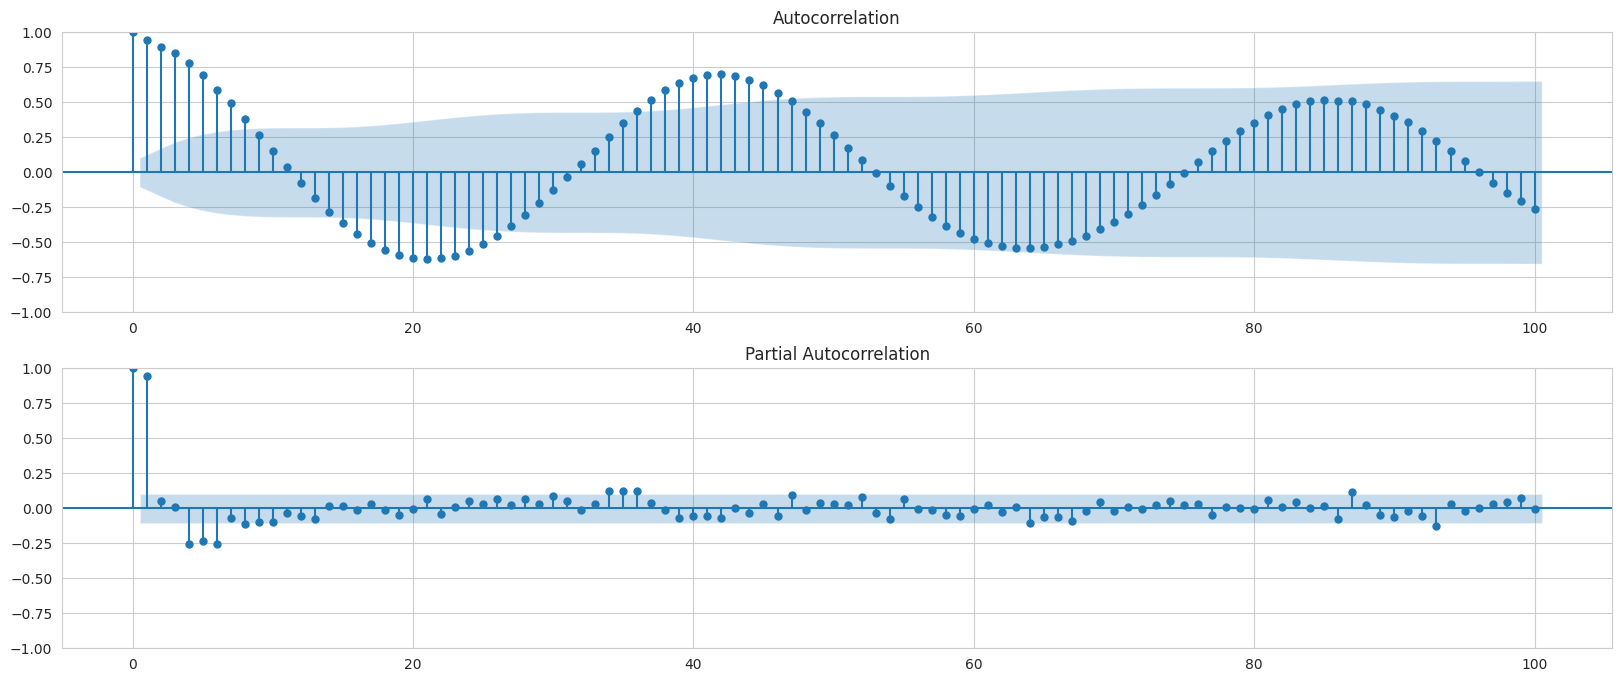

In [29]:
plot_acf_pacf(data_resample['Mean Total Sunspot Number'], acf_lags=100, pacf_lags=100)

##SARIMA model - Seasonal Autoregressive Integrated Moving Average
SARIMA(p,d,q)(P,D,Q)S require stationary time series data.

**Parameters:**

AR (p, P): Autoregressive. Shows how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use

I (d, D): Integrated. The degree of differencing -> Dickey-fuller test; d - show how many times have we derivated our series 1-step-wise; D - show how many times have we derivated our series Period-step-wise

MA (q, Q): Moving Average. Shows how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use

**Stationarity (Dickey-Fuller test)**

Let's determine d parameter.

*Null Hypothesis (H0)*: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

*Alternate Hypothesis (H1)*: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [30]:
adfuller_test(data_resample['Mean Total Sunspot Number'])

Dickey-Fuller test: 7.681261890429969e-10
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


According to the DF test, let's set **d = 0**. But to deal with non-stationarity it is important to perform differencing.

**Heteroscedasticity**

Let's apply Box-Cox transformation.

There are zero values in the data.


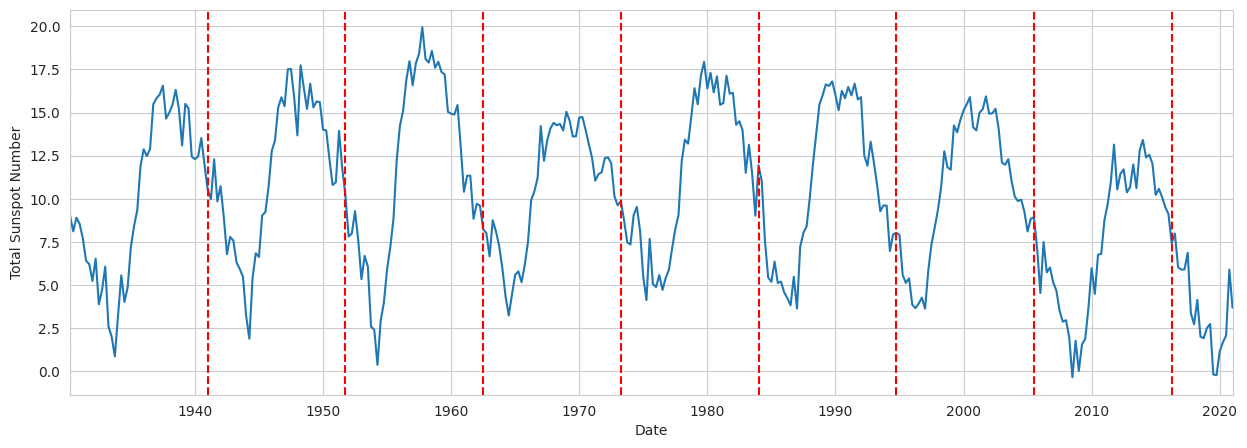

In [31]:
# Сheck for values close to 0.0
zero_flag = False
eps = 0.001
if len(np.where(np.isclose(data_resample['Mean Total Sunspot Number'],0.0))) != 0:
    print("There are zero values in the data.")
    zero_flag = True

if zero_flag:
    data_transform = [elem + eps for elem in data_resample['Mean Total Sunspot Number']]

data_resample["Box_Cox"], lmbda = stats.boxcox(data_transform)
plot_seasons(data_resample["Box_Cox"], round(period_resample))

**Deseasonalize a Time Series**

Seasonal difference the series (subtract the value of previous season from the current value) -> D = 1

In [32]:
period_resample

43.142857142857146

Dickey-Fuller test: 4.068711929162321e-05
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


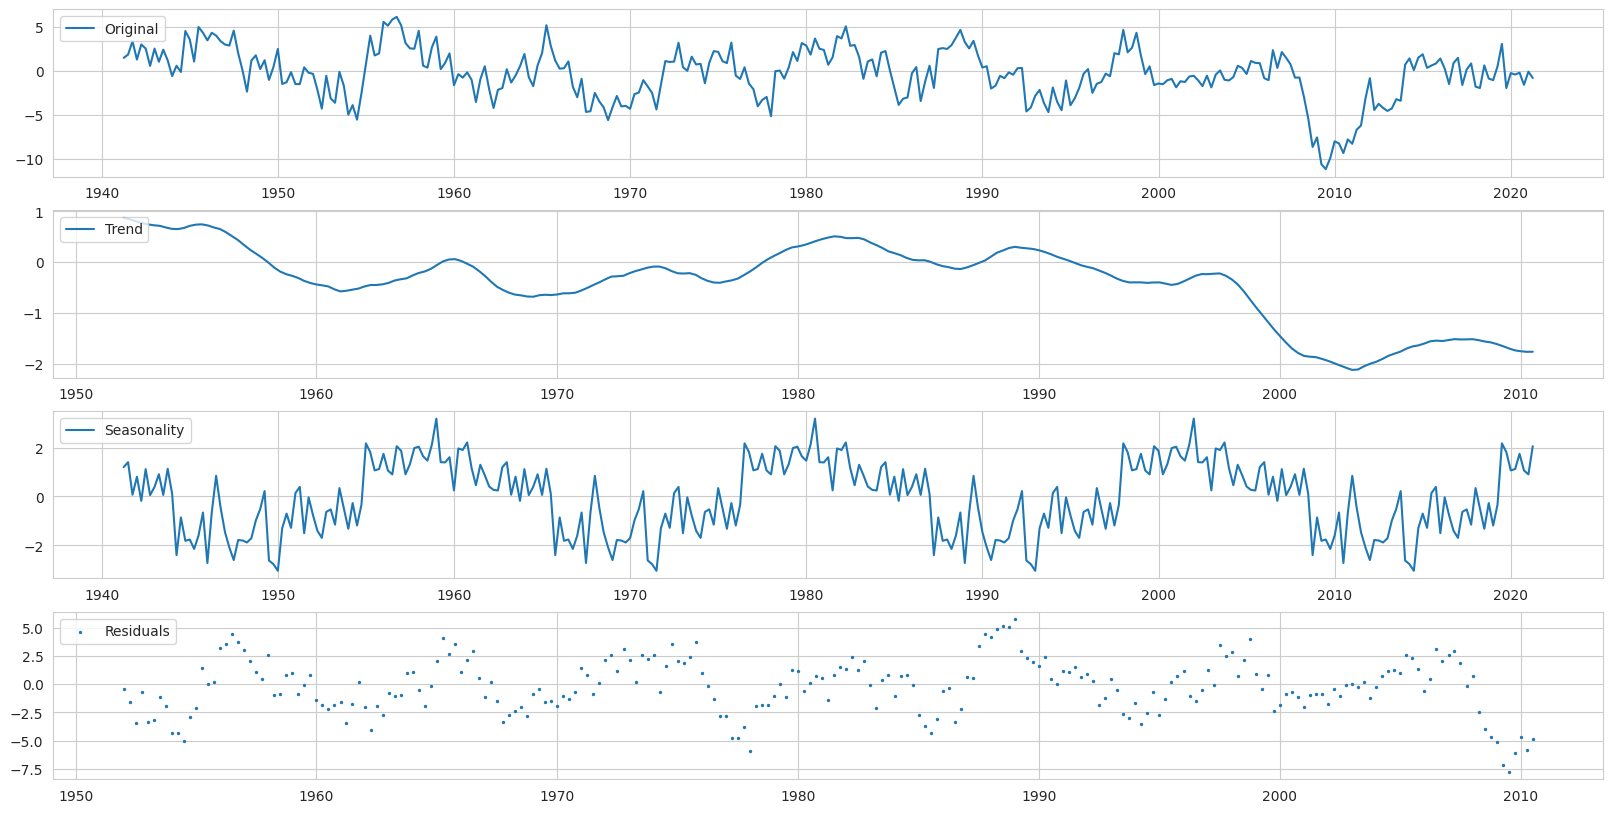

In [33]:
data_resample["Season_diff"] = data_resample["Box_Cox"] - data_resample["Box_Cox"].shift(round(period_resample))
plot_decomposition(data_resample["Season_diff"][round(period_resample):], data_resample.index[round(period_resample):], period=86)
adfuller_test(data_resample["Season_diff"][round(period_resample):])

Let's try to apply additional 1-step differencing (set **d = 1**).

Dickey-Fuller test: 2.3183663429094295e-30
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


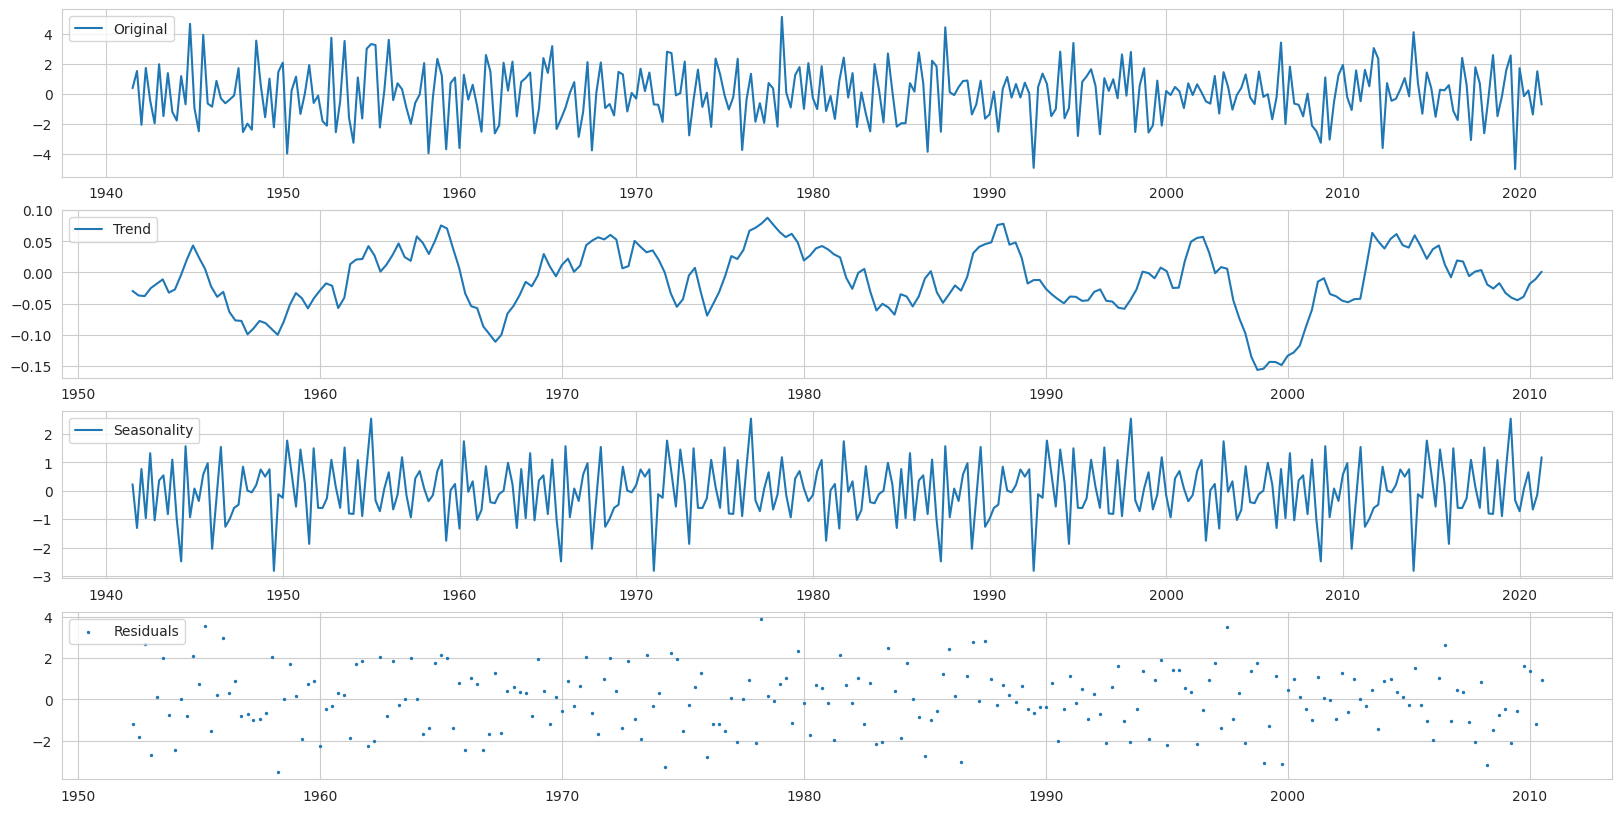

In [34]:
data_resample["Season_diff2"] = data_resample["Season_diff"] - data_resample["Season_diff"].shift(1)
plot_decomposition(data_resample["Season_diff2"][round(period_resample)+1:], data_resample.index[round(period_resample)+1:], period=86)
adfuller_test(data_resample["Season_diff2"][round(period_resample)+1:])

**Autocorrelation and Partial Autocorrelation**

Let's determine the optimal AR (p) and MA (q) parameters.

p = last non-seasonal lag with significant partial autocorrelation (PACF) = 2

q = last non-seasonal lag with significant autocorrelation (ACF) = 2

P = last seasonal lag with significant partial autocorrelation (PACF) = 2

Q = last seasonal lag with significant autocorrelation (ACF) = 9




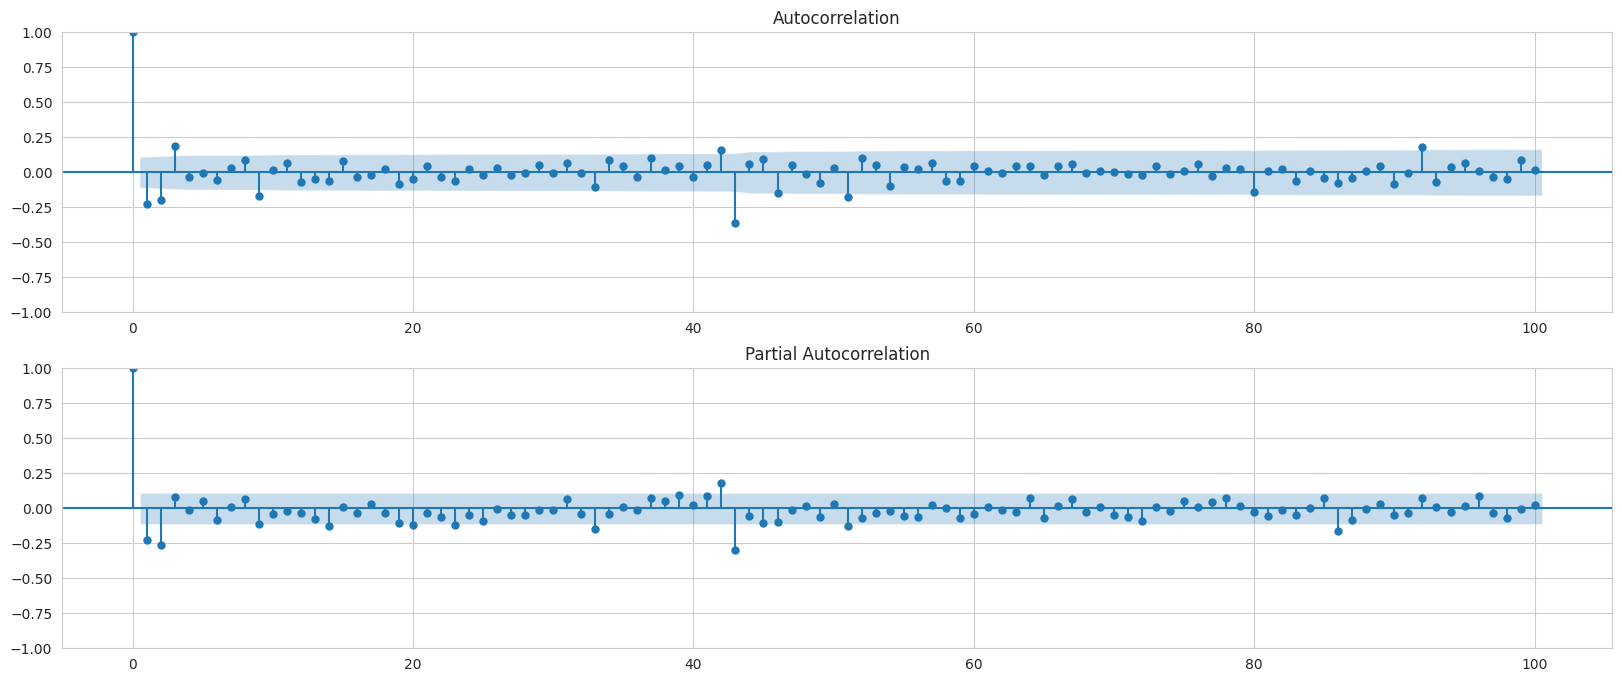

In [35]:
plot_acf_pacf(data_resample["Season_diff2"][round(period_resample)+1:], acf_lags=100, pacf_lags=100)

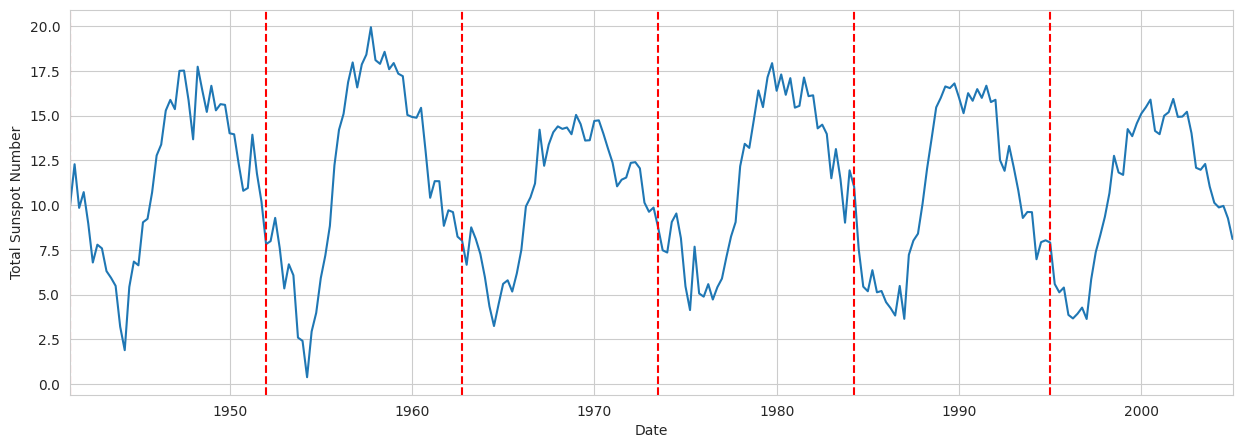

In [36]:
# Train-Test splitting
sarima_train_data, sarima_test_data = train_test_split(data_resample["Box_Cox"][round(period_resample)+1:])
plot_seasons(sarima_train_data, round(period_resample))

In [37]:
best_sarima = arima.auto_arima(sarima_train_data, start_p=0, d=1, start_q=0, max_p=2,
                               max_d=1, max_q=2, start_P=0, D=1, start_Q=0,
                               max_P=1, max_D=1, max_Q=8, m=round(period_resample),
                               seasonal=True, trace=True, suppress_watnings=True, error_actions='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[43]             : AIC=850.049, Time=0.86 sec
 ARIMA(1,1,0)(1,1,0)[43]             : AIC=810.510, Time=2.87 sec
 ARIMA(0,1,1)(0,1,1)[43]             : AIC=inf, Time=8.82 sec
 ARIMA(1,1,0)(0,1,0)[43]             : AIC=841.825, Time=0.37 sec
 ARIMA(1,1,0)(1,1,1)[43]             : AIC=inf, Time=11.93 sec
 ARIMA(1,1,0)(0,1,1)[43]             : AIC=inf, Time=2.94 sec
 ARIMA(0,1,0)(1,1,0)[43]             : AIC=818.035, Time=1.12 sec
 ARIMA(2,1,0)(1,1,0)[43]             : AIC=796.937, Time=1.95 sec
 ARIMA(2,1,0)(0,1,0)[43]             : AIC=827.091, Time=0.38 sec
 ARIMA(2,1,0)(1,1,1)[43]             : AIC=inf, Time=9.35 sec
 ARIMA(2,1,0)(0,1,1)[43]             : AIC=inf, Time=4.11 sec
 ARIMA(2,1,1)(1,1,0)[43]             : AIC=798.392, Time=4.41 sec
 ARIMA(1,1,1)(1,1,0)[43]             : AIC=803.976, Time=4.61 sec
 ARIMA(2,1,0)(1,1,0)[43] intercept   : AIC=798.926, Time=4.74 sec

Best model:  ARIMA(2,1,0)(1,1,0)[43]          
Tota

In [38]:
best_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  256
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 43)   Log Likelihood                -394.469
Date:                            Wed, 27 Sep 2023   AIC                            796.937
Time:                                    19:16:04   BIC                            810.363
Sample:                                06-30-1941   HQIC                           802.364
                                     - 03-31-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2624      0.064     -4.105      0.000      -0.388      -0.137
ar.L2         -0.2706      0.069     -3.914      0.000      -0.406      -0.135
ar.S.L43      -0.4210      0.070     -6.046      0.000      -0.558      -0.285
sigma2         2.3234      0.253      9.201      0.000       1.828       2.818
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.94   Prob(JB):                         0.76
Heteroskedasticity (H):               0.52   Skew:                             0.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

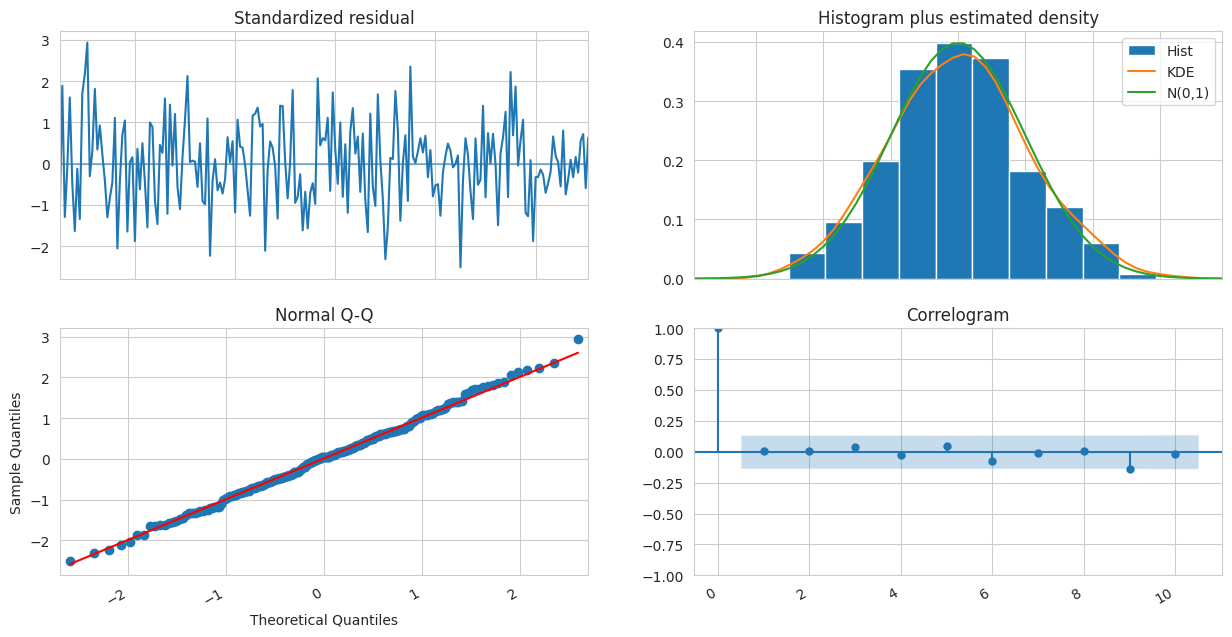

In [39]:
# Display the model diagnostics
fig = best_sarima.plot_diagnostics(figsize=(15, 8))
fig.autofmt_xdate()
plt.show()

In [40]:
best_sarima = sm.tsa.statespace.SARIMAX(sarima_train_data, trend='n', order=(2,1,0), seasonal_order=(1,1,0,43))
sarima_model = best_sarima.fit()
adfuller_test(sarima_model.resid[round(period_resample):])
print("Student test: p =", stats.ttest_1samp(sarima_model.resid[round(period_resample):], 0)[1])

Dickey-Fuller test: 2.5068975245394796e-27
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
Student test: p = 0.868023502874399


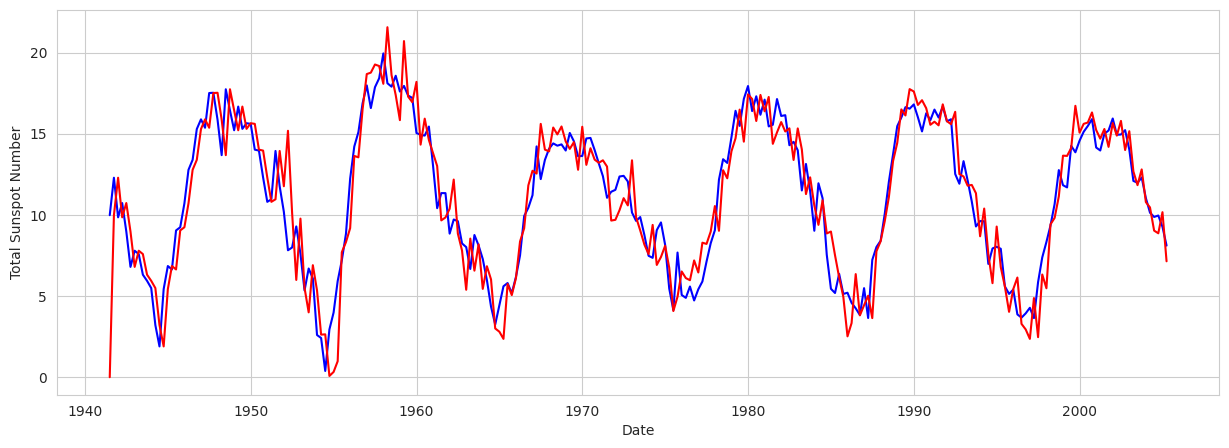

In [41]:
data_resample["sarima_prediction"] = sarima_model.predict()
plt.figure(figsize=(15, 5))
plt.plot(sarima_train_data, color="blue")
plt.plot(data_resample["sarima_prediction"], color="red")
plt.xlabel("Date")
plt.ylabel("Total Sunspot Number")
plt.show()

**Forecast SARIMA**

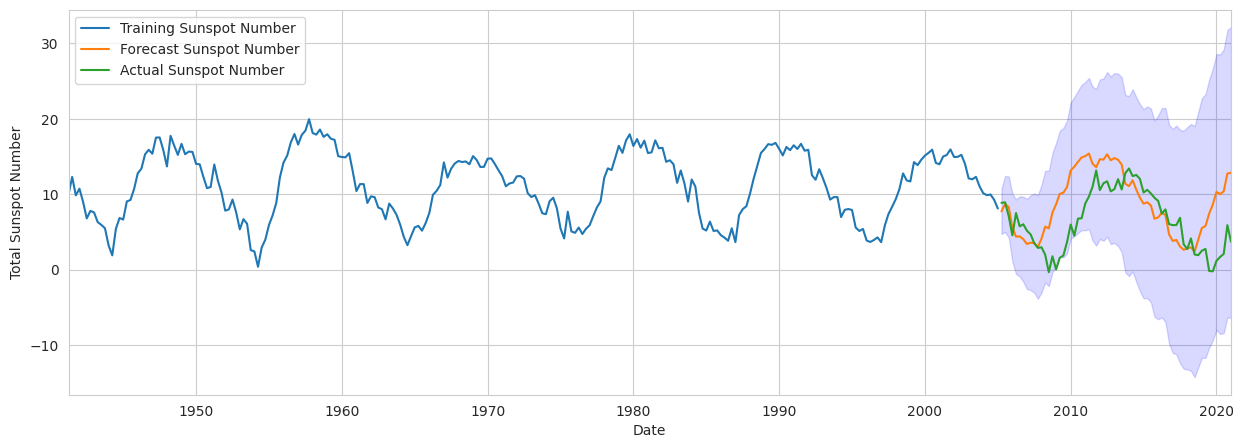

In [42]:
# Get forecast and confidence intervals
forecast = sarima_model.get_forecast(steps=len(sarima_test_data))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = sarima_train_data.plot(figsize=(15,5))
forecast_values.plot()
sarima_test_data.plot(ax=ax)
plt.fill_between(forecast_values.index,
                 confidence_intervals['lower Box_Cox'],
                 confidence_intervals['upper Box_Cox'],
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Sunspot Number',
            'Forecast Sunspot Number',
            'Actual Sunspot Number'],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Total Sunspot Number')
plt.show()

In [43]:
forecast_values.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 64 entries, 2005-06-30 to 2021-03-31
Freq: Q-DEC
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
64 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


            sarima
r2_score   -1.1954
MAPE      556.5000


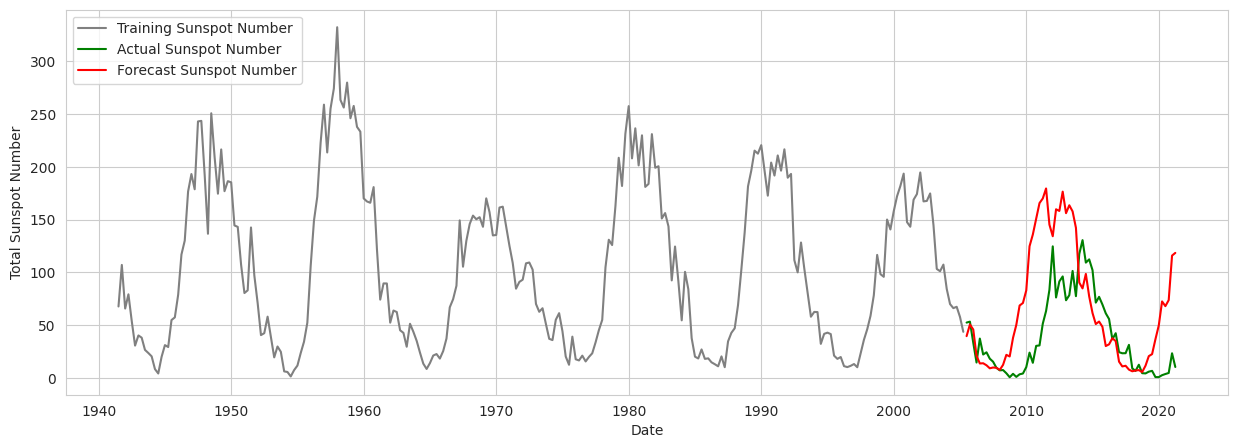

In [290]:
data_forecast_df = pd.DataFrame({'test_sarima': invboxcox(sarima_test_data, lmbda)})
data_forecast_df["forecast_sarima"] = invboxcox(forecast_values, lmbda)
metrics_df = pd.DataFrame({'sarima': [calculate_r2_score(data_forecast_df['test_sarima'], data_forecast_df["forecast_sarima"]),
                           calculate_mape(data_forecast_df['test_sarima'], data_forecast_df["forecast_sarima"])]})
metrics_df.index = ["r2_score", "MAPE"]

print(metrics_df)

plt.figure(figsize=(15,5))
plt.plot(invboxcox(sarima_train_data, lmbda), color="grey")
plt.plot(data_forecast_df['test_sarima'], color="green")
plt.plot(data_forecast_df['forecast_sarima'], color="red")
plt.legend(['Training Sunspot Number',
            'Actual Sunspot Number',
            'Forecast Sunspot Number'],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Total Sunspot Number')
plt.show()

##Multi-step LSTM


The duration of the season is equal to: 43.666666666666664 months (3.638888888888889 years)


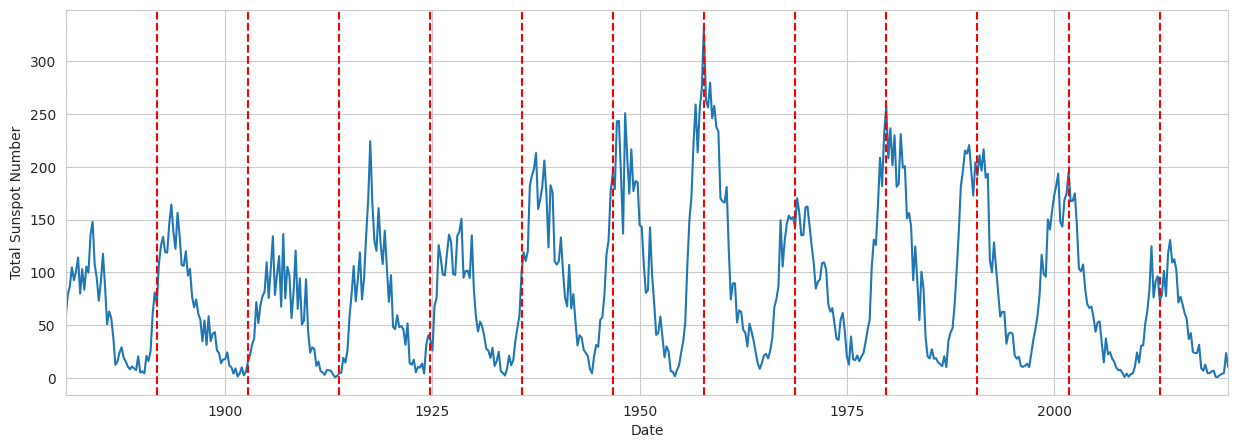

In [248]:
lstm_data =  pd.DataFrame({'Mean Total Sunspot Number': []})
lstm_data['Mean Total Sunspot Number'] = resample_quarter(dataset["Monthly Mean Total Sunspot Number"][-round(period*13):])

lstm_period = calculate_period(lstm_data['Mean Total Sunspot Number'] )

In [249]:
X_train, y_train, X_test, y_test, scaler = prepare_data(lstm_data, n_lag=round(lstm_period))

406 68


In [252]:
# hyperparameters initialization and training of the model

# historical lag - multiple of 12 - length of the input vector
n_lag = round(lstm_period)
# forecasting period
n_seq = len(X_test)
# number of epochs for training
n_epochs = 20
# batch size
n_batch = 4
# number of LSTM cells
n_neurons = 64

model, history_loss, history_val_loss = fit_lstm(X_train, y_train, n_neurons,
                                                 n_lag, n_epochs, n_batch)

0
92/92 [==============================] - 6s 63ms/step - loss: 0.0423 - mae: 0.1594 - val_loss: 0.0292 - val_mae: 0.1451
2
92/92 [==============================] - 7s 76ms/step - loss: 0.0130 - mae: 0.0880 - val_loss: 0.0103 - val_mae: 0.0792
4
92/92 [==============================] - 6s 64ms/step - loss: 0.0094 - mae: 0.0733 - val_loss: 0.0075 - val_mae: 0.0707
6
92/92 [==============================] - 6s 66ms/step - loss: 0.0074 - mae: 0.0663 - val_loss: 0.0065 - val_mae: 0.0652
8
92/92 [==============================] - 7s 76ms/step - loss: 0.0067 - mae: 0.0630 - val_loss: 0.0066 - val_mae: 0.0675
10
92/92 [==============================] - 8s 82ms/step - loss: 0.0062 - mae: 0.0614 - val_loss: 0.0062 - val_mae: 0.0645
12
92/92 [==============================] - 6s 63ms/step - loss: 0.0058 - mae: 0.0588 - val_loss: 0.0060 - val_mae: 0.0648
14
92/92 [==============================] - 8s 86ms/step - loss: 0.0059 - mae: 0.0594 - val_loss: 0.0061 - val_mae: 0.0650
16
92/92 [===========

[0.005398556590080261] [0.006356826052069664]


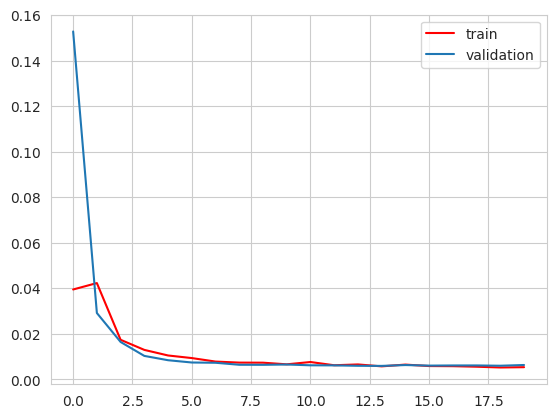

In [253]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

In [255]:
y_pred = model.predict(X_test)
y_pred = [x[0] for x in y_pred]
y_pred = [x[0] for x in scaler.inverse_transform(pd.DataFrame(y_pred))]
y_test_real = [x[0] for x in scaler.inverse_transform(pd.DataFrame(y_test))]

3/3 [==============================] - 0s 29ms/step


            sarima      lstm
r2_score   -1.1954    0.5367
MAPE      556.5000  372.8000


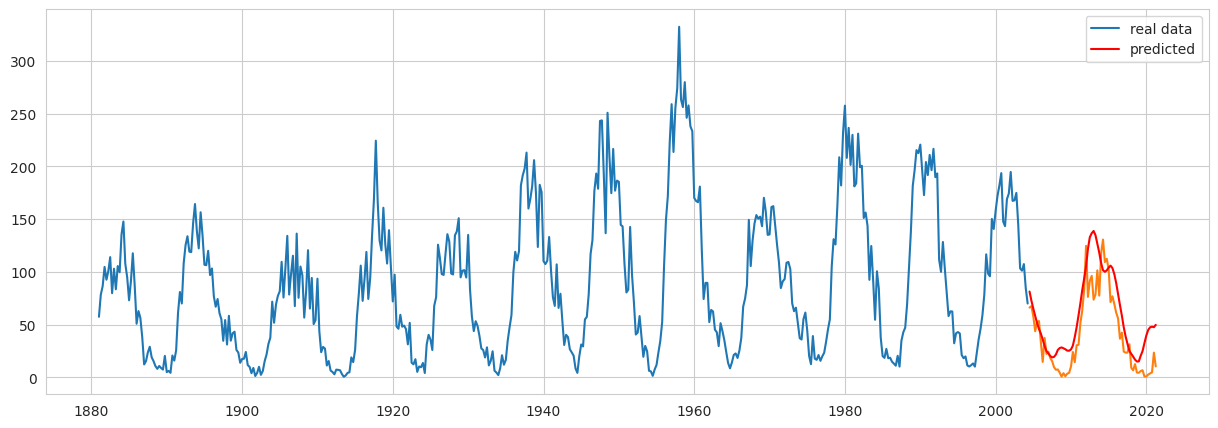

In [291]:
metrics_df["lstm"] = [calculate_r2_score(y_test_real, y_pred), calculate_mape(np.array(y_test_real), np.array(y_pred))]

print(metrics_df)

plt.figure(figsize=(15,5))
plt.plot(lstm_data.index[:-len(y_pred)], lstm_data[:-len(y_pred)], label="real data")
plt.plot(lstm_data.index[-len(y_pred):], y_test_real)
plt.plot(lstm_data.index[-len(y_pred):], y_pred, color="red", label="predicted")

plt.legend()
plt.show()

##Visualization and Conclusion

As we can see in the picture below, the most suitable model for predicting the number of sunspots is Multi-step LSTM. This conclusion is also confirmed by metrics (MAPE and R^2).

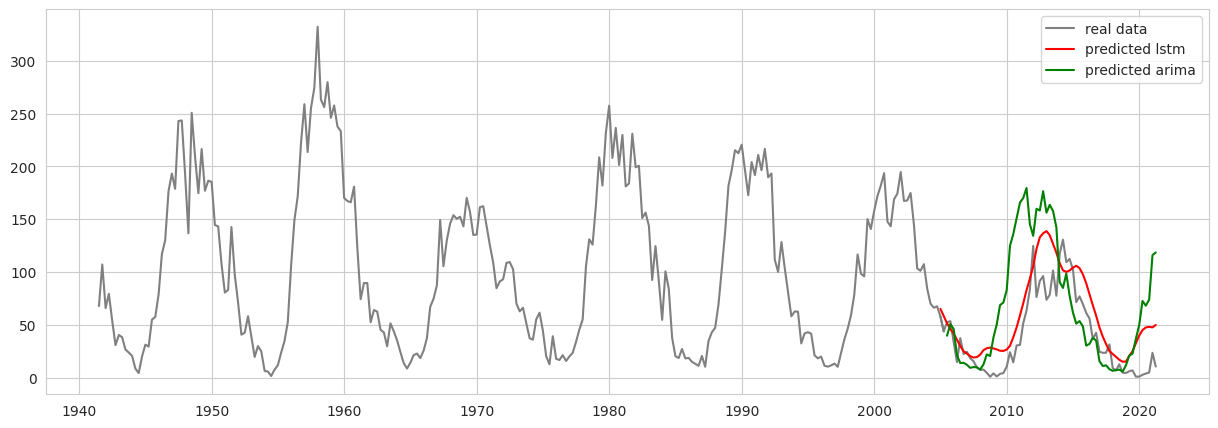

In [282]:
plt.figure(figsize=(15,5))
plt.plot(invboxcox(sarima_train_data, lmbda), color="grey", label="real data")
plt.plot(lstm_data.index[-len(y_pred)+2:], y_test_real[2:], color="grey")
plt.plot(lstm_data.index[-len(y_pred)+2:], y_pred[2:], color="red", label="predicted lstm")
plt.plot(data_forecast_df['forecast_sarima'], color="green", label="predicted arima")

plt.legend()
plt.show()